In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils_data as ud
import utils_info as info
import constants as cons
import utils_matrixes as um
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from itertools import product
import time
sns.set()
start_time = time.time()


In [2]:
'''
    General settings
'''

target_name = cons.TIMESERIES_TARGET_NAME
residual_target_name = cons.RESIDUAL_TARGET_NAME
temperature_name = cons.TEMPERATURE_NAME
source_folder = cons.SOURCE_FILES_FOLDER
calendar_folder = cons.CALENDAR_FOLDER
forecast_folder = cons.FORECAST_FILE_FOLDER
model_folder = cons.MODEL_FOLDER
benchmark_folder = cons.BENCHMARK_FOLDER
log_folder = cons.LOGS_FOLDER

company = 'Company'
hub = 'HUB2'               

model_info = info.get_model_info(company, hub)
min_lag_une = 72
model_settings = info.get_model_settings_xgboost(company, hub, min_lag_une)

In [3]:
'''

Training settings

'''

save_model = False  # put True when ready to write and don't forget turn on mode 'finished_model'
save_benchmark = False

date_start = model_settings['train_date_start']
date_end = model_settings['train_date_end']

if 'horison' in model_settings:
    horison = model_settings['horison']
else:
    horison = cons.FORECAST_HORISON

max_lag = (model_settings['simple_lags_settings'][-1]).astype(int)

benchmark_modelname = hub + '_lags_' + str(model_settings['min_lag']) + '_network_train_result.xlsx'
benchmark_filename = ud.get_filename(benchmark_folder, company, hub, benchmark_modelname)
benchmark_sheetname = 'xgboost'


In [4]:
'''
    Main
'''

data = ud.get_data(model_info['actuals_filename'], date_start, date_end, model_info['actuals_dateformat'])

if 'temperature' in model_settings['weather_settings']:
    temperature = ud.get_data(model_info['temperature_actuals_filename'],
                              date_start, date_end, model_info['temperature_actuals_dateformat'])
    data = ud.add_temperature(data, temperature, model_settings['temperature_settings'])

data, model_settings, predictors_name, target_name = \
    um.get_network_input_matrix(data, model_info, model_settings, date_start, date_end)
data = ud.clean_data(data)

predictors = data[predictors_name]
target = data[target_name]
dates = data.index.values

Source data is ready
Target:  residual
Predictors (66):  Index(['temperature', 'holidays', 'holidays_bunch', 'holidays_number_in_bunch',
       'holidays_always', 'sin_1', 'sin_2', 'sin_3', 'sin_4', 'sin_5', 'sin_6',
       'sin_7', 'weekly', 'monthly', 'trend', 'hourly_0', 'hourly_1',
       'hourly_2', 'hourly_3', 'hourly_4', 'hourly_5', 'hourly_6', 'hourly_7',
       'hourly_8', 'hourly_9', 'hourly_10', 'hourly_11', 'hourly_12',
       'hourly_13', 'hourly_14', 'hourly_15', 'hourly_16', 'hourly_17',
       'hourly_18', 'hourly_19', 'hourly_20', 'hourly_21', 'hourly_22',
       'hourly_23', 'daily_0', 'daily_1', 'daily_2', 'daily_3', 'daily_4',
       'daily_5', 'daily_6', 'sun_profile', 'consumption_lag_72',
       'consumption_lag_96', 'consumption_lag_120', 'consumption_lag_144',
       'consumption_lag_168', 'consumption_lag_192', 'consumption_lag_336',
       'consumption_lag_504', 'consumption_lag_672', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_24', 'tem

  0%|          | 0/243 [00:00<?, ?it/s]

Validation set is 12 months
Shape of train predictors:  (36576, 66)
Shape of validation predictors:  (9048, 66)


/home/jane/3005/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jane/3005/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


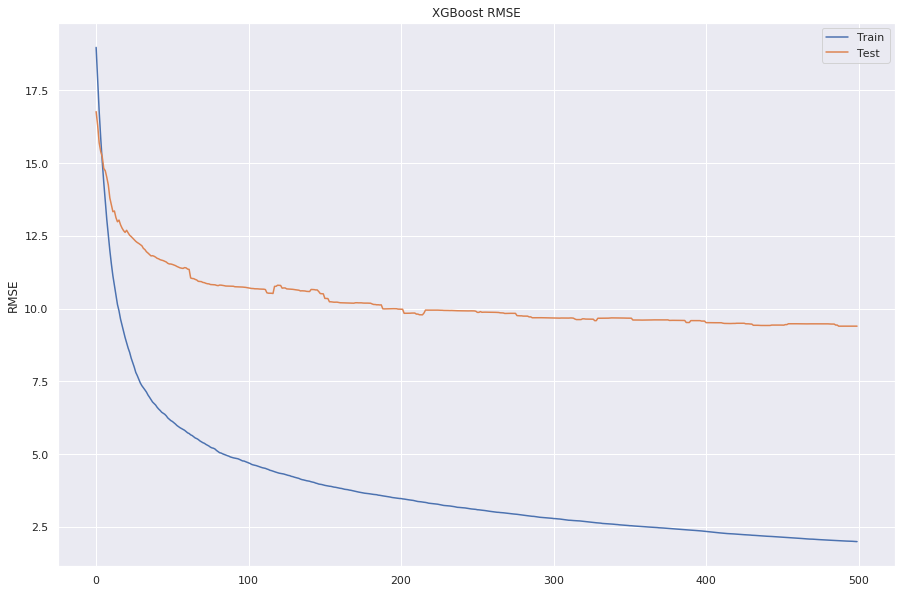

Accuracy: MAE =  7.05  MWh,  MAPE =  2.04 %, MaxAPE =  18.57 %, APE > 5 =  5.46 %
Step_24:
Accuracy: MAE =  1.50  MWh,  MAPE =  0.43 %, MaxAPE =  4.86 %, APE > 5 =  0.00 %
Accuracy: MAE =  6.61  MWh,  MAPE =  1.91 %, MaxAPE =  18.01 %, APE > 5 =  4.61 %
error on last 5  days:
Accuracy: MAE =  7.04  MWh,  MAPE =  2.49 %, MaxAPE =  6.02 %, APE > 5 =  6.67 %


In [5]:
'''
    Model
'''
mode = 'finished_model'   #'hp_optimization' or 'check_split_dates' or 'finished_model'

if mode == 'check_split_dates':
    #Add dates which you interested in
    split_dates = [pd.datetime(2018, 8, 30, 23, 0, 0), pd.datetime(2019, 3, 1, 23, 0, 0), 
                   pd.datetime(2019, 6, 1, 23, 0, 0), pd.datetime(2019, 9, 1, 23, 0, 0)]
else:  
    split_dates = [model_settings['train_date_split']]

#Check performance of model with different train subsets on the same test days
test_days = 5
#Min error for searching best hyperparameters
min_error = 100

n_estimators = [400, 500, 600]
max_depth = [6, 7, 8]
learning_rate = [0.06, 0.08, 0.1]  
subsample = [0.6, 0.7, 0.8]
colsample_bytree = [0.7, 0.8, 0.9] 
#min_child_weight 
parameters = product(n_estimators, max_depth, learning_rate, subsample, colsample_bytree) 
param_list = list(parameters)


for param in tqdm(param_list):

    for sdate in split_dates:
        
        model_settings['train_date_split'] = sdate #this string was added to not change autoregression function
        t = pd.date_range(date_start, model_settings['train_date_split'], freq='D')
        train_split_index = len(t) * int(cons.FORECAST_HORISON / horison) - max_lag
    
        train_predictors = predictors[:train_split_index]
        train_target = target[:train_split_index]
        train_dates = dates[:train_split_index]
    
        valid_predictors = predictors[train_split_index:]
        valid_target_tr = target[train_split_index:]
        valid_dates = dates[train_split_index:]
    
        print('Validation set is %d months' %(valid_predictors.shape[0]/720))
        print('Shape of train predictors: ', train_predictors.shape)
        print('Shape of validation predictors: ', valid_predictors.shape)
        
        if mode == 'hp_optimization':
            print('\nPARAMETERS SET:n_estimators = %d, max_depth = %d, learning_rate = %.2f, subsample = %.1f, colsample bytree= %.1f:\n'
                                                % (param[0], param[1],param[2], param[3], param[4]))
            gb = xgb.XGBRegressor(n_estimators = param[0], max_depth= param[1], learning_rate = param[2], 
                              subsample = param[3], colsample_bytree = param[4])
       
        else:
            gb = xgb.XGBRegressor(**model_settings['xgboost_train_settings'][str(min_lag_une)])
        
        evaluation_set = [(train_predictors, train_target), (valid_predictors, valid_target_tr)]
        gb.fit(train_predictors, train_target, eval_metric = ['rmse'],
                eval_set = evaluation_set, verbose = False) #early_stopping_rounds=10
            
        '''
        Plot learning curve
        '''
        errors = gb.evals_result()
        epochs = range(0, len(errors['validation_0']['rmse']))
        
        fig, ax = plt.subplots(figsize = (15,10))
        ax.plot(epochs, errors['validation_0']['rmse'], label = 'Train')
        ax.plot(epochs, errors['validation_1']['rmse'], label = 'Test')
        ax.legend()
        plt.ylabel('RMSE')
        plt.title('XGBoost RMSE')
        plt.show()
        
  
        '''
        Assess results
        '''
        model_settings['xgboost'] = gb
        model_target = gb.predict(valid_predictors)
        
        if model_settings['target'] == 'residual':
            model_target = pd.DataFrame(model_target, columns=[cons.RESIDUAL_TARGET_NAME])
        else:
            model_target = pd.DataFrame(model_target, columns=[cons.TIMESERIES_TARGET_NAME])
            
        mask = data.index.isin(valid_dates)
        valid_target = data[cons.TIMESERIES_TARGET_NAME][mask].values
        
        if model_settings['target'] == 'residual':
            model_target = data['global_trend'][mask].values + model_target.values.ravel()
        else:
            model_target = model_target.values.ravel()
        
        current_error = ud.get_accuracy(model_target, valid_target)[1]
        
        #Best hyperparameters are searching for first the split date in the list split_dates
        if mode == 'hp_optimization':
            if (current_error < min_error) & (sdate == split_dates[0]):
                min_error = current_error
                best_parameters = param
        '''
        
        Autoregression
        
        '''
        model_full = gb.predict(predictors)
        model_full = pd.DataFrame(model_full, columns=[target_name])
        dates = dates.reshape(-1, 1).ravel()
        mask = data.index.isin(dates)
        if model_settings['target'] == 'residual':
            model_full = data['global_trend'][mask].values + model_full.values.ravel()
        else:
            model_full = model_full.values.ravel()
        prediction = np.zeros(len(data))
        prediction[mask] = model_full
        data['prediction'] = prediction
        data, model_settings, pred_name = um.get_autoregress_results(data, model_settings, 'train')
        
        #Check performance of model with different train subsets on the same test days
        print('error on last', test_days, ' days:')
        ud.get_accuracy(model_target[-1*test_days*24:], valid_target[-1*test_days*24:]);
        
    if mode != 'hp_optimization':
        break

if mode == 'hp_optimization':
    print('\nMin error is %.2f with best parameters: \n n_estimators = %d, max_depth = %d, lr = %.2f, subsample = %.1f, colsample bytree= %.1f:\n' % (
                                                                                                  min_error, 
                                                                                                  best_parameters[0],
                                                                                                  best_parameters[1],
                                                                                                  best_parameters[2],
                                                                                                  best_parameters[3],
                                                                                                  best_parameters[4]))


In [6]:
'''
    Saving model when training is done

'''

if save_benchmark:
    cmp_df = data[[cons.TIMESERIES_TARGET_NAME, pred_name]].copy()
    cmp_df.rename(columns={cons.TIMESERIES_TARGET_NAME: 'Fact', pred_name: 'Prediction'}, inplace=True)
    cmp_df.index.name = cons.TIMESTEP_NAME
    # mask = cmp_df.index >= pd.datetime(2012, 1, 29)
    # cmp_df[mask].to_excel(benchmark_filename, sheet_name=benchmark_sheetname)
    cmp_df.to_excel(benchmark_filename, sheet_name=benchmark_sheetname)

if save_model:
    ud.save_model_settings(model_settings, company, hub, 'xgboost')

print("--- %s seconds ---" % (time.time() - start_time))

--- 102.81607580184937 seconds ---


In [7]:
# importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
d = gb.get_booster().get_score(importance_type='weight')

In [1]:
choosen_features = []
s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
for i in range(15, 67, 1):
    for k, v in s[:i]:
        #if v > 500:
        choosen_features.append(k)
    
    predictors = data[choosen_features]
    train_predictors = predictors[:train_split_index]
    train_target = target[:train_split_index]
    train_dates = dates[:train_split_index]
    valid_predictors = predictors[train_split_index:]
    valid_target_tr = target[train_split_index:]
    valid_dates = dates[train_split_index:]
    print('Validation set is %d months' %(valid_predictors.shape[0]/720))
    print('Shape of train predictors: ', train_predictors.shape)
    print('Shape of validation predictors: ', valid_predictors.shape)
    
    gb = xgb.XGBRegressor(**model_settings['xgboost_train_settings'][str(min_lag_une)])
    
    evaluation_set = [(train_predictors, train_target), (valid_predictors, valid_target_tr)]
    gb.fit(train_predictors, train_target, eval_metric = ['rmse'],
            eval_set = evaluation_set, verbose = False) #early_stopping_rounds=10
        
    '''
    Plot learning curve
    '''
    errors = gb.evals_result()
    epochs = range(0, len(errors['validation_0']['rmse']))
    
    fig, ax = plt.subplots(figsize = (15,10))
    ax.plot(epochs, errors['validation_0']['rmse'], label = 'Train')
    ax.plot(epochs, errors['validation_1']['rmse'], label = 'Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE')
    plt.show()
    
    '''
    Assess results
    '''
    model_settings['xgboost'] = gb
    model_target = gb.predict(valid_predictors)
    
    if model_settings['target'] == 'residual':
        model_target = pd.DataFrame(model_target, columns=[cons.RESIDUAL_TARGET_NAME])
    else:
        model_target = pd.DataFrame(model_target, columns=[cons.TIMESERIES_TARGET_NAME])
        
    mask = data.index.isin(valid_dates)
    valid_target = data[cons.TIMESERIES_TARGET_NAME][mask].values
    
    if model_settings['target'] == 'residual':
        model_target = data['global_trend'][mask].values + model_target.values.ravel()
    else:
        model_target = model_target.values.ravel()
    
    ud.get_accuracy(model_target, valid_target)[1]
    
    '''
    
    Autoregression
    
    '''
    model_full = gb.predict(predictors)
    model_full = pd.DataFrame(model_full, columns=[target_name])
    dates = dates.reshape(-1, 1).ravel()
    mask = data.index.isin(dates)
    if model_settings['target'] == 'residual':
        model_full = data['global_trend'][mask].values + model_full.values.ravel()
    else:
        model_full = model_full.values.ravel()
    prediction = np.zeros(len(data))
    prediction[mask] = model_full
    data['prediction'] = prediction
    data, model_settings, pred_name = um.get_autoregress_results(data, model_settings, 'train')
    choosen_features

In [ ]:
'''
Train & predict on subset of features using features importances
'''
from sklearn.feature_selection import SelectFromModel

thresholds = np.sort(gb.feature_importances_)
print(len(thresholds))
thresholds = thresholds[thresholds > 0]
print(thresholds, len(thresholds))
xgb.plot_importance(gb)
plt.show()

for thresh in thresholds:
    selection = SelectFromModel(gb, threshold = thresh, prefit = True)
    select_train_predictors = selection.transform(train_predictors)
    select_valid_predictors = selection.transform(valid_predictors)
    
    selection_model = xgb.XGBRegressor(**model_settings['xgboost_train_settings'][str(min_lag_une)])
    evaluation_set = [(select_train_predictors, train_target), (select_valid_predictors, valid_target_tr)]
    selection_model.fit(select_train_predictors, train_target, eval_metric = ['rmse'],
                eval_set = evaluation_set, verbose = False)
    
    model_target = selection_model.predict(select_valid_predictors)
    
    if model_settings['target'] == 'residual':
        model_target = pd.DataFrame(model_target, columns=[cons.RESIDUAL_TARGET_NAME])
    else:
        model_target = pd.DataFrame(model_target, columns=[cons.TIMESERIES_TARGET_NAME])
        
    mask = data.index.isin(valid_dates)
    valid_target = data[cons.TIMESERIES_TARGET_NAME][mask].values
    
    if model_settings['target'] == 'residual':
        model_target = data['global_trend'][mask].values + model_target.values.ravel()
    else:
        model_target = model_target.values.ravel()
    print('Thresh = %.3f, n=%d' % (thresh, select_train_predictors.shape[1]))
    ud.get_accuracy(model_target, valid_target)
    print(predictors.columns[gb.feature_importances_ >= thresh])
    xgb.plot_importance(selection_model)
    plt.show()
    errors = selection_model.evals_result()
    epochs = range(0, len(errors['validation_0']['rmse']))
        
    fig, ax = plt.subplots(figsize = (15,10))
    ax.plot(epochs, errors['validation_0']['rmse'], label = 'Train')
    ax.plot(epochs, errors['validation_1']['rmse'], label = 'Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE')
    plt.show()
    
#     fig, ax = plt.subplots(figsize = (15,10))
#     ax.plot(epochs, errors['validation_0']['mae'], label = 'Train')
#     ax.plot(epochs, errors['validation_1']['mae'], label = 'Test')
#     ax.legend()
#     plt.ylabel('MAE')
#     plt.title('XGBoost MAE')
#     plt.show()

    '''
    
    Autoregression
    
    '''
    select_predictors = selection.transform(predictors)
    model_full = selection_model.predict(select_predictors)
    model_full = pd.DataFrame(model_full, columns=[target_name])
    dates = dates.reshape(-1, 1).ravel()
    mask = data.index.isin(dates)
    if model_settings['target'] == 'residual':
        model_full = data['global_trend'][mask].values + model_full.values.ravel()
    else:
        model_full = model_full.values.ravel()
    prediction = np.zeros(len(data))
    prediction[mask] = model_full
    data['prediction'] = prediction
    data, model_settings, pred_name = um.get_autoregress_results(data, model_settings, 'train')